# Определение стоимости автомобилей


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных

Признаки:

•	DateCrawled — дата скачивания анкеты из базы

•	VehicleType — тип автомобильного кузова

•	RegistrationYear — год регистрации автомобиля

•	Gearbox — тип коробки передач

•	Power — мощность (л. с.)

•	Model — модель автомобиля

•	Kilometer — пробег (км)

•	RegistrationMonth — месяц регистрации автомобиля

•	FuelType — тип топлива

•	Brand — марка автомобиля

•	Repaired — была машина в ремонте или нет

•	DateCreated — дата создания анкеты

•	NumberOfPictures — количество фотографий автомобиля

•	PostalCode — почтовый индекс владельца анкеты (пользователя)

•	LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

Значение метрики RMSE должно быть меньше 2500


## Подготовка данных

Импортируем необходимые нам библиотеки и функции

In [ ]:
!pip install -q lightgbm 

In [1]:
import pandas as pd
import numpy as np
import time


import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from catboost import CatBoostRegressor, Pool
from sklearn.dummy import DummyRegressor

import phik

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345

### Напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), построение гистограмм для визуализации распределения данных в столбцах), наличия явных дубликатов, построения матрицы корреляции с визуализацией в seaborn.¶

In [3]:
def get_info(data):
    display('Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:', data.duplicated().sum())
    display(data.describe())
    data.hist(figsize=(9, 9));
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(data.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', 
                annot_kws={"fontsize":8})

### Cчитываем данные из файла , сохраняем его в переменной df, получаем общую информацию о датафрейме с помощью функции get_info()¶

'Вывод первых 5-ти строк датасета'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Количество явных дубликатов: 4


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


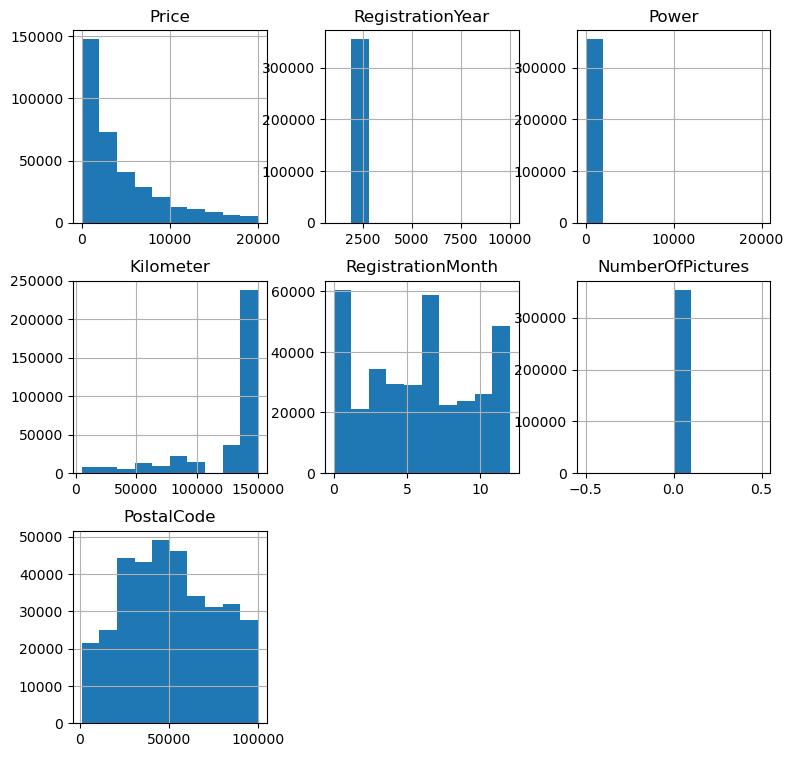

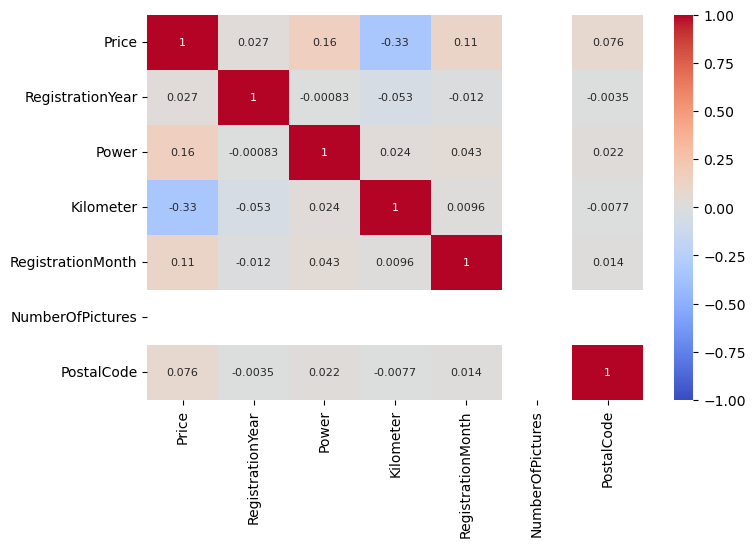

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv(r'D:\Мои Документы\Desktop\Материалы по учебе\Численные методы\autos.csv')
    
get_info(df)

### Посмотрим матрицу корреляцию phik

In [5]:
df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox','Power', 'Model', 'Kilometer', 'FuelType', 'Brand','Repaired']].phik_matrix(interval_cols = ['Price', 'RegistrationYear', 'Power'])


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.268157,0.013889,0.323641,0.005752,0.579008,0.322957,0.257367,0.355422,0.380373
VehicleType,0.268157,1.000000,NaN,0.289237,0.011764,0.917251,0.189528,0.330157,0.633333,0.084344
RegistrationYear,0.013889,NaN,1.000000,0.003470,0.088713,0.083360,0.184909,0.040116,0.051203,0.010072
Gearbox,0.323641,0.289237,0.003470,1.000000,0.010497,0.647244,0.019098,0.151407,0.520822,0.043662
Power,0.005752,0.011764,0.088713,0.010497,1.000000,0.000000,0.009108,0.010882,0.004458,0.011677
Model,0.579008,0.917251,0.083360,0.647244,0.000000,1.000000,0.438144,0.554911,0.998376,0.159132
Kilometer,0.322957,0.189528,0.184909,0.019098,0.009108,0.438144,1.000000,0.172488,0.284604,0.124804
FuelType,0.257367,0.330157,0.040116,0.151407,0.010882,0.554911,0.172488,1.000000,0.322331,0.044514
Brand,0.355422,0.633333,0.051203,0.520822,0.004458,0.998376,0.284604,0.322331,1.000000,0.105511
Repaired,0.380373,0.084344,0.010072,0.043662,0.011677,0.159132,0.124804,0.044514,0.105511,1.000000


Тут еще модно увидить высокую зависимость между Моделью и брендом, моделью и типом кузова. Прослеживается большая зависимость между ценой и моделью.

**Вывод:**
Из полученной инфоромации мы видем, что размер дата фрейиа - 354369 строк на 16 столбцов. Есть пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired. Выявлено 4 полных дубликата, их надо удалить.  Тип данныйх в столбце DateCreated и LastSeen необходимо перевести в формат даты. Видим, что в столбце NumberOfPictures	все значения равны 0, следовательно данный столбец для нас неинформативен, его можно удалить. Также можно удалить столбцы DateCrawled (дата скачивания анкеты из базы) и PostalCode (почтовый индекс владельца анкеты) - т.к. вряд ли эти факторы могут повлиять на стоимость машины. Из матрицы корреляции видно, что мультиколлинеарных признаков нет. Наибольшая зависимость прослеживается между стоимостью и пробегом (0.33), чем больше пробег, тем ниже стоимость, что логично. Также в ряде столбцов (RegistrationYear, Power, RegistrationMonth) мы видим, что есть анамольные значения.

### Удаляем дубликаты методом drop_duplicates() с удалением старых индексов и проверяем, что все сделали корректно.

In [6]:
df.duplicated().sum()

4

In [7]:
df= df.drop_duplicates().reset_index(drop=True)
len(df)

354365

### Меняем тип данных в столбцах  DateCreated и LastSeen 

In [8]:
df['DateCreated']= pd.to_datetime(df['DateCreated'])
df['LastSeen']= pd.to_datetime(df['LastSeen'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  object        
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

#### Найдем разницу между датой последней активности и датой создания анкеты, сохраним ее в столбце duration_sale. И посмотроим график зависимости цены от данной величины.

In [9]:
df['duration_sale'] = df['LastSeen'] - df['DateCreated']
df['duration_sale'] = df['duration_sale'].dt.days
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,14
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,14
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,22
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,6


In [10]:
df['duration_sale'].describe()

count    354365.000000
mean          8.678058
std           8.639415
min           0.000000
25%           2.000000
50%           6.000000
75%          13.000000
max         759.000000
Name: duration_sale, dtype: float64

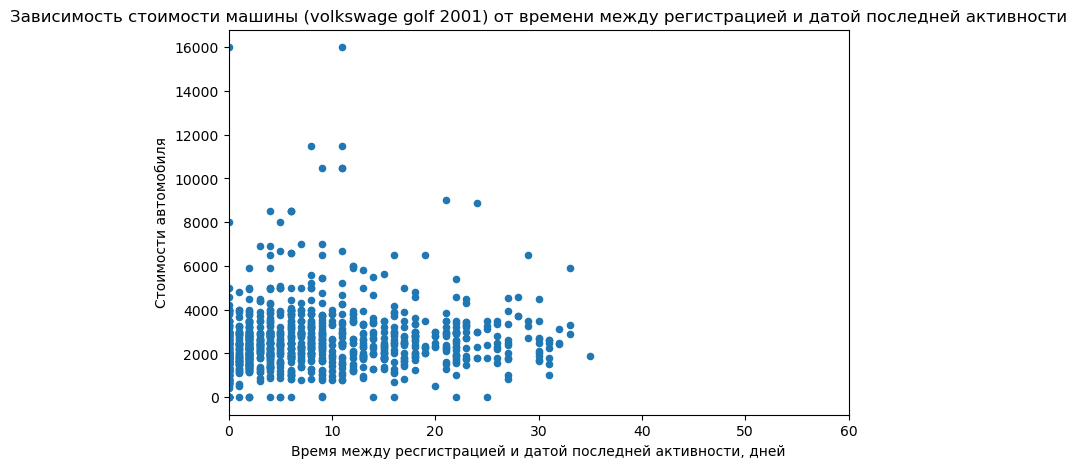

In [11]:
df.query('RegistrationYear == 2001 and Model=="golf" and Brand== "volkswagen"').plot(x='duration_sale', y='Price', kind='scatter', figsize=(8, 5), xlim=(0,60))
plt.title('Зависимость стоимости машины (volkswage golf 2001) от времени между регистрацией и датой последней активности')
plt.xlabel('Время между ресгистрацией и датой последней активности, дней')
plt.ylabel('Стоимости автомобиля')
plt.show()

### Исследуем данные в столбце Price, т.к. тут минимальное значение 0. Посмотрим данные, где цена машины меньше 20.

In [12]:
display(df.query('Price < 20'))
display(df.query('Price < 20')['Price'].unique())
df.query('Price < 10 and Repaired == "no"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58,4
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34,1
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38,8
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54,9
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354201,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08,21
354234,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23,17
354244,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24,14
354273,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32,2


array([ 0,  1,  3,  2, 12,  9, 14,  8, 17,  5, 13, 10, 15, 11, 16,  4,  7,
       19, 18], dtype=int64)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58,4
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54,9
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11,0,55122,2016-03-26 23:15:49,15
466,2016-03-24 10:58:40,0,NaN,2016,auto,197,3er,150000,12,gasoline,bmw,no,2016-03-24,0,99867,2016-03-25 19:46:09,1
579,2016-03-27 11:37:43,0,sedan,1996,manual,170,5er,150000,0,petrol,bmw,no,2016-03-27,0,48529,2016-03-27 11:37:43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353575,2016-04-02 21:36:16,0,coupe,1999,manual,101,a3,150000,1,petrol,audi,no,2016-04-02,0,44652,2016-04-06 22:16:11,4
353859,2016-03-26 19:58:27,0,sedan,1995,manual,90,mondeo,100000,1,petrol,ford,no,2016-03-26,0,28325,2016-04-06 10:45:37,11
353939,2016-03-20 23:44:12,0,sedan,1999,manual,150,golf,125000,10,petrol,volkswagen,no,2016-03-20,0,36304,2016-03-23 10:16:33,3
353991,2016-03-08 16:45:49,0,sedan,1991,manual,133,100,150000,6,petrol,audi,no,2016-03-08,0,4319,2016-03-12 00:16:44,4


In [13]:
print(len(df.query('Price < 100'))/len(df)*100)

3.757143058710651


#### Так как не могу объяснить природу  значений стоимости машин меньше 100 (машины разного возраста, с разным пробегом, есть как бывшие в ремонте, так и нет) и процент таким машин около 3.7 %, то удаляю их.

In [14]:
df = df.query('Price >= 100')
len(df)

341051

### Исследуем данные в столбце VehicleType. Из предварительного анализа данных, мы видели, что в данном столбце были пропуски. Посмотрим, какие еще уникальные  значения есть в данном столбце.

In [15]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [16]:
df.query('VehicleType.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,14
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46,0
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,8
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,6
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354334,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04,6
354342,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,0,61169,2016-03-08 21:28:38,1
354347,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,0,87700,2016-03-12 14:16:51,1
354357,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,0,51371,2016-03-13 01:44:13,4


In [17]:
df.pivot_table(index=['Brand', 'Model', 'VehicleType'], values='RegistrationYear', aggfunc='count')

RegistrationYear
Brand      Model    VehicleType                  
alfa_romeo 145      coupe                       2
                    other                       1
                    sedan                      12
                    small                      19
           147      coupe                      26
...                                           ...
volvo      v70      coupe                       1
                    wagon                     598
           xc_reihe sedan                       3
                    suv                       216
                    wagon                      41

[1397 rows x 1 columns]

#### Так как пропусков достаточно много и внутри одного  бренда и модели может быть несколько типов кузова, то пропущенные значения заменяем на unknown.

In [18]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['VehicleType'].isna().sum()

0

### Исследуем данные в столбце RegistrationYear. Из предварительного анализа данных, мы видели, что в данном столбце есть аномальные значения.

#### Посмотри, какие уникальные значения есть в данном столбце методом value_counts()

In [19]:
df['RegistrationYear'].value_counts()

2000    22661
1999    21845
2005    21363
2006    19641
2001    19573
        ...  
2200        1
8888        1
2290        1
9450        1
1946        1
Name: RegistrationYear, Length: 138, dtype: int64

In [20]:
display(df.query('RegistrationYear < 1950'))
df.query('RegistrationYear < 1950')['RegistrationYear'].unique()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47,8
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25,0,58135,2016-03-25 15:58:21,0
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15,0,79288,2016-04-07 05:15:34,23
6977,2016-03-24 08:37:22,135,unknown,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-24,0,19374,2016-04-06 20:46:08,13
10183,2016-03-27 13:59:08,1250,unknown,1910,NaN,0,other,5000,0,NaN,audi,NaN,2016-03-27,0,18445,2016-04-07 10:45:31,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340755,2016-04-04 23:55:47,700,unknown,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04,0,86343,2016-04-05 06:44:07,1
346042,2016-03-26 16:45:28,18900,suv,1943,manual,60,other,150000,3,petrol,volkswagen,no,2016-03-26,0,51065,2016-03-26 16:45:28,0
351678,2016-03-12 00:57:39,11500,unknown,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11,0,16515,2016-04-05 19:47:27,25
353527,2016-03-16 21:56:55,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016-03-16,0,23936,2016-03-30 18:47:41,14


array([1910, 1945, 1925, 1000, 1941, 1500, 1929, 1940, 1949, 1937, 1800,
       1234, 1400, 1948, 1932, 1255, 1942, 1935, 1933, 1936, 1923, 1930,
       1001, 1944, 1943, 1938, 1934, 1928, 1600, 1111, 1039, 1300, 1931,
       1602, 1947, 1927, 1946], dtype=int64)

#### Удалим строчик, где год регистрации автомобиля меньше 1910, в этом году уже такие компании как ford, opel, fiat уже производили автомобили.

In [21]:
df = df.query('RegistrationYear >= 1910')
len(df)

341008

In [22]:
df['YearCreated'] = df['DateCreated'].dt.year
df.query('RegistrationYear > YearCreated')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale,YearCreated
22,2016-03-23 14:52:51,2900,unknown,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,8,2016
26,2016-03-10 19:38:18,5555,unknown,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,6,2016
48,2016-03-25 14:40:12,7750,unknown,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44,6,2016
51,2016-03-07 18:57:08,2000,unknown,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08,0,2016
57,2016-03-10 20:53:19,2399,unknown,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37,15,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354108,2016-03-11 15:49:51,3600,unknown,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11,0,32339,2016-03-12 05:45:02,1,2016
354136,2016-03-29 16:47:29,1000,unknown,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29,0,38315,2016-04-06 02:44:27,8,2016
354199,2016-03-17 00:56:26,2140,unknown,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04,12,2016
354249,2016-03-25 09:37:59,1250,unknown,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,0,45527,2016-04-06 07:46:13,12,2016


#### Получилось, что достаточно много машин, у которых год регистрации автомобиля больше, чем год создания анкеты, при этом вполне реалистичный (2017, 2018). Так как у нас нет точного понимания, какая информация отражена в колонке дата создания анкеты и дата последней активности пользователя,  не будем учитывать данные столбцы и столбцы, которые из них получили, для обучения моделей. 

In [23]:
df['YearCreated'].unique()

array([2016, 2015, 2014], dtype=int64)

In [24]:
df.query('RegistrationYear > 2018')['RegistrationYear'].unique()

array([3200, 9999, 8888, 2200, 4100, 3000, 2066, 2019, 5300, 9000, 2900,
       6000, 5900, 5911, 5000, 4000, 8500, 3700, 3800, 4800, 7000, 2290,
       9450, 2500, 5555, 5600, 2222, 2800, 4500, 7800, 7100, 8200],
      dtype=int64)

#### Удалим строки, где гож регистрации превышает 2016. И проверим процент удаленной информации.

In [25]:
df = df.query('RegistrationYear <= 2016')
len(df)

327321

### Исследуем данные в столбце Gearbox. Из предварительного анализа данных, мы видели, что в данном столбце были пропуски. Посмотрим, какие еще уникальные значения есть в данном столбце.

In [26]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

#### Заменим nan на  unknown.

In [27]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Gearbox'].isna().sum()

0

### Исследуем данные в столбце Model. Из предварительного анализа данных, мы видели, что в данном столбце были пропуски. Посмотрим, какие еще уникальные значения есть в данном столбце.

In [28]:
display(df['Model'].isna().sum())
df['Model'].unique()

15169

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'to

#### Заполняем пропуски значением unknown

In [29]:
df['Model'] = df['Model'].fillna('unknown')
df['Model'].isna().sum()

0

### Исследуем данные в столбце FuelType. Из предварительного анализа данных, мы видели, что в данном столбце были пропуски. Посмотрим, какие еще уникальные значения есть в данном столбце.

In [30]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

#### Заполняем пропуски значением unknown

In [31]:
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'].isna().sum()

0

### Исследуем данные в столбце Repaired	. Из предварительного анализа данных, мы видели, что в данном столбце были пропуски. Посмотрим, какие еще уникальные значения есть в данном столбце.

In [32]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

#### Заполняем пропуски значением unknown

In [33]:
df['Repaired'] = df['Repaired'].fillna('unknown')
df['Repaired'].isna().sum()

0

### Исследуем данные в столбце Power. Из предварительного анализа видим, что в столбце есть анамальные значения, посмотрим более подробно машины мощность которых меньше 40 и более 200.

In [34]:
df.query('Power < 30')['Power'].value_counts()

0     31611
26      257
5        99
18       50
23       42
27       37
29       32
4        30
24       28
11       28
1        23
20       20
14       19
15       18
12       16
25       15
19       13
6        11
10       11
7        10
2         9
3         8
16        7
17        7
8         7
13        6
9         5
21        5
22        5
28        5
Name: Power, dtype: int64

In [35]:
df.query('Power > 400')['Power'].value_counts()

450     82
435     34
500     33
476     31
420     22
        ..
850      1
700      1
2331     1
2789     1
1241     1
Name: Power, Length: 302, dtype: int64

In [36]:
df.query('Power == 0').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,duration_sale,YearCreated
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57,14,2016
15,2016-03-11 21:39:15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,unknown,2016-03-11,0,24148,2016-03-19 08:46:47,8,2016
32,2016-03-15 20:59:01,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43,2,2016
37,2016-03-28 17:50:15,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02,2,2016
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32,18,2016


#### Из полученных данных видно, что 35737 машин с 0 значением мощности. Такой мощности не может быть, удалим эти данные, также оганичимся мощностью 40 и исклбчим машины с можностью больше  равно 500.

#### Удалим выбросы по мощности. Слева ограничемся 40 справа 500, т.к. после встречаются только еденичные машины.

In [39]:
df = df.loc[(df['Power'] > 40) & (df['Power'] < 500)] 
len(df)

293701

count    293701.000000
mean        121.013238
std          53.076685
min          41.000000
25%          77.000000
50%         113.000000
75%         150.000000
max         490.000000
Name: Power, dtype: float64


Text(0, 0.5, 'Частота')

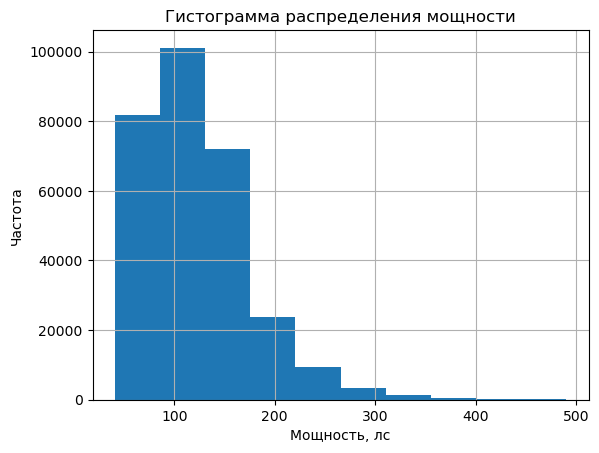

In [40]:
print(df['Power'].describe())
df['Power'].hist()
plt.title('Гистограмма распределения мощности')
plt.xlabel('Мощность, лс')
plt.ylabel('Частота')


### Удаляем столбцы, которые мы не будем использовать в дальнейшем.

In [41]:
df = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 
         'Kilometer', 'FuelType',  'Brand', 'Repaired']]

### Проверяем, что у нас получилось в итоге.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293701 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             293701 non-null  int64 
 1   VehicleType       293701 non-null  object
 2   RegistrationYear  293701 non-null  int64 
 3   Gearbox           293701 non-null  object
 4   Power             293701 non-null  int64 
 5   Model             293701 non-null  object
 6   Kilometer         293701 non-null  int64 
 7   FuelType          293701 non-null  object
 8   Brand             293701 non-null  object
 9   Repaired          293701 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.6+ MB


### Исследуем уникальные значения в столбце Kilometer

In [48]:
df['Kilometer'].unique()

array([125000, 150000, 90000, 30000, 70000, 100000, 60000, 5000, 20000,
       80000, 50000, 40000, 10000], dtype=object)

Из полученных данных видим, что тут всего несколько значений, переведем данный признак в категориальный.

### Поменяем тип данных в столбце Kilometer  на object. 

In [43]:
df['Kilometer'] = df['Kilometer'].astype('object')


### Проверяем не появились ли у нас явные дубликаты после удаления столбцов

In [44]:
df.duplicated().sum()

38954

#### Удаляем дубликаты

In [45]:
df= df.drop_duplicates().reset_index(drop=True)
len(df)

254747

**Вывод**
- На данном этапе удалили явные дубликаты и столбцы, которые не планиурем использовать для обучения модели. 
- Заполнили пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired значение unknown.
- Заменили значение 0 в столбце Power на медианное значение в зависимости от модели машины, удалили выбросы.
- Удалили анамальные значения в столбце RegistrationYear и Price


## Обучение моделей

### Подготовим выборки для обучения моделей. Разобьем их на обучающую и тестовую в соотношении 75 - 25. Целевой признак  - Price, удаляем его из признаков.

In [46]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('Price', axis =1), 
          df.Price, test_size=0.25, random_state=RANDOM_STATE)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
target_test.shape

(191060, 9)
(63687, 9)
(191060,)


(63687,)

### Определим категориальные и количественные признаки

In [47]:
cat_columns = features_train.select_dtypes(include='object').columns
num_columns = features_train.select_dtypes(include='number').columns
print(cat_columns)
num_columns

Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired'],
      dtype='object')


Index(['RegistrationYear', 'Power'], dtype='object')

Для обучения выберем следующие модели (RandomForestRegressor, Ridge, CatBoostRegressor, LightGBM) и подготовим для них данные.

### Исследуем модель случайный лес. 

#### Создадим Column_transformer для модели случайный лес, затем pipline и с помощью RandomizedSearchCV будем подбирать гиперпараметры. Используемая метрика для оценки - RMSE. RMSE это квадратный корень из MSE, поэтому будем отслеживать эту метрику при подборе гиперпараметров, с учетом того, что нам нужно найти минимальное значение MSE.

In [49]:
column_transformer_rforest = make_column_transformer((StandardScaler(),num_columns), 
                                                     (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
                                                      , cat_columns),
                                                     remainder = 'passthrough')

In [50]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(column_transformer_rforest, model)
pipline_rf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['RegistrationYear', 'Power'], dtype='object')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=12345))])

In [51]:
param_rf = {
    'randomforestregressor__n_estimators': range(10, 60, 10),
    'randomforestregressor__max_depth': range(1, 10),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}

grid_rf = RandomizedSearchCV(
    pipline_rf, 
    param_rf, 
    n_iter=20,
    cv=5,
    verbose=5,
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)
grid_rf

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               Index(['RegistrationYear', 'Power'], dtype='object')),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer'...
                                              RandomForestRegressor(random_state=12345))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(1, 10),
                                        'randomforestregressor__min_samples_leaf': (1,
                                                                                    2,
                                                                                    3,
                                                                                    4),
                                        'randomforestregressor__min_samples_split': (2,
                                                                                     3,
                                                                                     4),
                                        'randomforestregressor__n_estimators': range(10, 60, 10)},
                   random_state=12345, scoring='neg_mean_squared_error',
                   verbose=5)

In [52]:
%%time
grid_rf.fit(features_train, target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 3min 32s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               Index(['RegistrationYear', 'Power'], dtype='object')),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer'...
                                              RandomForestRegressor(random_state=12345))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(1, 10),
                                        'randomforestregressor__min_samples_leaf': (1,
                                                                                    2,
                                                                                    3,
                                                                                    4),
                                        'randomforestregressor__min_samples_split': (2,
                                                                                     3,
                                                                                     4),
                                        'randomforestregressor__n_estimators': range(10, 60, 10)},
                   random_state=12345, scoring='neg_mean_squared_error',
                   verbose=5)

In [53]:
grid_rf.best_params_

{'randomforestregressor__n_estimators': 20,
 'randomforestregressor__min_samples_split': 3,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__max_depth': 9}

In [54]:
grid_rf.best_score_

-3848175.38677112

In [55]:
rmse_rf = (grid_rf.best_score_*(-1))**0.5
rmse_rf

1961.6766774295706

In [56]:
cv_scores = cross_val_score(grid_rf,  features_train, target_train, cv=5,  scoring='neg_mean_squared_error')
cv_scores

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


array([-3895237.35571213, -3812764.78873401, -3845897.04710066,
       -3719662.11451347, -3967315.62779533])

In [57]:
rmse_rf_cv= (cv_scores*-1)**0.5
print(rmse_rf_cv)
rmse_rf_cv_mean = rmse_rf_cv.mean().round(2)
rmse_rf_cv_mean

[1973.63556811 1952.63022325 1961.09587912 1928.64255748 1991.81214671]


1961.56

#### Обучим модель случайный лес с параметрами найденными выше: 
({'randomforestregressor__n_estimators': 20,
 'randomforestregressor__min_samples_split': 3,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__max_depth': 9})
 
Получим предсказания и оценим качество модели (RMSE).

In [58]:
%%time
model_bp = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=20, min_samples_split=3, min_samples_leaf=3,
                                 max_depth=9)
pipline_rf_bp = make_pipeline(column_transformer_rforest, model_bp)
start_time_rf = time.time()
pipline_rf_bp.fit(features_train, target_train)
end_time_rf = time.time()
fit_time_rf = end_time_rf - start_time_rf
print(fit_time_rf)

13.227542638778687
Wall time: 13.2 s


In [59]:
%%time
start_time_rf = time.time()
predictions = pipline_rf_bp.predict(features_train)
end_time_rf = time.time()
pred_time_rf = end_time_rf - start_time_rf
print(pred_time_rf)

1.7519893646240234
Wall time: 1.75 s


#### Посмотри, какие признаки были наиболее значимы для данной модели.

In [60]:
feature_importance = pipline_rf_bp.named_steps['randomforestregressor'].feature_importances_
feature_names = column_transformer_rforest.get_feature_names_out()
feature_names

array(['standardscaler__RegistrationYear', 'standardscaler__Power',
       'ordinalencoder__VehicleType', 'ordinalencoder__Gearbox',
       'ordinalencoder__Model', 'ordinalencoder__Kilometer',
       'ordinalencoder__FuelType', 'ordinalencoder__Brand',
       'ordinalencoder__Repaired'], dtype=object)

Text(0, 0.5, 'Признаки')

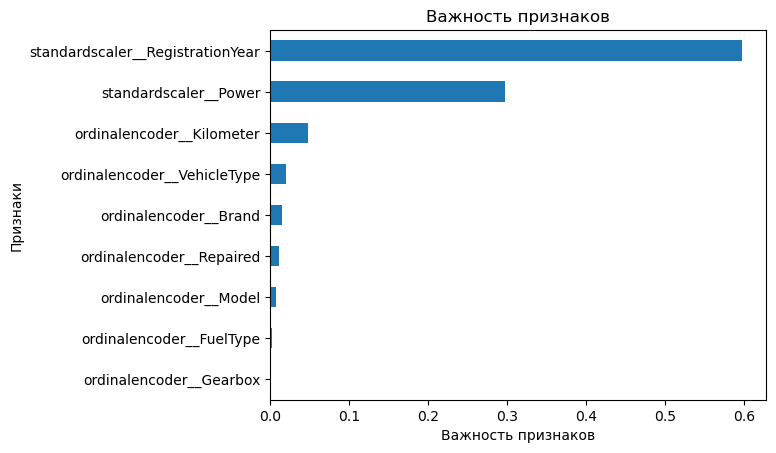

In [61]:
fi= pd.Series(feature_importance, index=feature_names).sort_values().plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')

Из данного графика видно, чтьо наиболее значимыми признаками для модели были RegistrationYear, Power, Kilometer.

### Исследуем модель Ridge.

#### Создадим Column_transformer для модели Ridge, затем pipline и с помощью GridSearchCV будем подбирать гиперпараметры. Так как это линейная моель, то тут будем использовать OneHotEncoder.  Используемая метрика для оценки - RMSE. RMSE это квадратный корень из MSE, поэтому будем отслеживать эту метрику при подборе гиперпараметров, с учетом того, что нам нужно найти минимальное значение MSE.

In [62]:
column_transformer_rd = make_column_transformer((StandardScaler(),num_columns), 
                                                     (OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
                                                      , cat_columns),
                                                     remainder = 'passthrough')
model_rd = Ridge(random_state=RANDOM_STATE)
pipline_rd = make_pipeline(column_transformer_rd, model_rd)
pipline_rd

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['RegistrationYear', 'Power'], dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired'],
      dtype='object'))])),
                ('ridge', Ridge(random_state=12345))])

In [63]:
param_rd = {
          'ridge__alpha': range(0,10,1)
}

grid_rd = GridSearchCV(pipline_rd, param_rd, cv=5, scoring='neg_mean_squared_error')
grid_rd.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['RegistrationYear', 'Power'], dtype='object')),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired'],
      dtype='object'))])),
                                       ('ridge', Ridge(random_state=12345))]),
             param_grid={'ridge__alpha': range(0, 10)},
             scoring='neg_mean_squared_error')

In [64]:
%%time
grid_rd.fit(features_train, target_train)

Wall time: 1min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['RegistrationYear', 'Power'], dtype='object')),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         Index(['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired'],
      dtype='object'))])),
                                       ('ridge', Ridge(random_state=12345))]),
             param_grid={'ridge__alpha': range(0, 10)},
             scoring='neg_mean_squared_error')

In [65]:
grid_rd.best_params_

{'ridge__alpha': 2}

In [66]:
grid_rd.best_score_

-6546343.282514019

In [67]:
rmse_rd = (grid_rd.best_score_*-1)**0.5
rmse_rd

2558.5822798014565

**Вывод** - данная модель не соответсвует требуемой точности

### Исследуем модель CatBoostRegressor

#### C помощью RandomizedSearchCV будем подбирать гиперпараметры

In [69]:
model_cb = CatBoostRegressor(random_seed=RANDOM_STATE,
                          silent=True,
                          cat_features=[0, 2, 4, 5, 6, 7, 8])

In [70]:
params_cb = {
    'learning_rate':[0.01, 0.1, 0.3],
    'iterations': [40, 60],
    'depth': [d for d in range(2, 10)],
}

grid_cbr = RandomizedSearchCV(model_cb,
                         params_cb,
                         n_iter=10,
                         cv=5,
                         scoring='neg_mean_squared_error',
                         verbose=False)

In [71]:
%%time
grid_cbr.fit(features_train,target_train)

Wall time: 2min 49s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000273E966A310>,
                   param_distributions={'depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'iterations': [40, 60],
                                        'learning_rate': [0.01, 0.1, 0.3]},
                   scoring='neg_mean_squared_error', verbose=False)

In [72]:
grid_cbr.best_params_

{'learning_rate': 0.3, 'iterations': 40, 'depth': 6}

In [73]:
rmse_cb = (grid_cbr.best_score_*-1)**0.5
rmse_cb

1759.313763851465

# Обучим модель CatBoostRegressore с параметрами найденными выше ({'learning_rate': 0.1, 'iterations': 60, 'depth': 9}). Получим предсказания и оценим качество модели (RMSE).

In [74]:
%%time
model_cb_bp = CatBoostRegressor(random_seed=RANDOM_STATE, silent=True, cat_features=[0, 2, 4, 5, 6, 7, 8], 
                          learning_rate=0.1, iterations=60, depth=9)
start_time_cb = time.time()
model_cb_bp.fit(features_train,target_train)
end_time_cb = time.time()
fit_time_cb = end_time_cb - start_time_cb
print(fit_time_cb)

7.0739970207214355
Wall time: 7.07 s


In [75]:
cv_scores_cb = cross_val_score(model_cb_bp,  features_train, target_train, cv=5,  scoring='neg_mean_squared_error')
rmse_cb_cv= (cv_scores_cb*-1)**0.5
print(rmse_cb_cv)
rmse_cb_cv_mean = rmse_cb_cv.mean().round(2)
rmse_cb_cv_mean

[1757.82348152 1718.51896383 1756.41947726 1717.46006428 1760.73864017]


1742.19

In [76]:
%%time
start_time_cb = time.time()
predictions_cb = model_cb_bp.predict(features_train)
end_time_cb = time.time()
pred_time_cb = end_time_cb - start_time_cb
print(pred_time_cb)

0.5741264820098877
Wall time: 574 ms


#### Посмотри, какие признаки были наиболее значимы для данной модели.

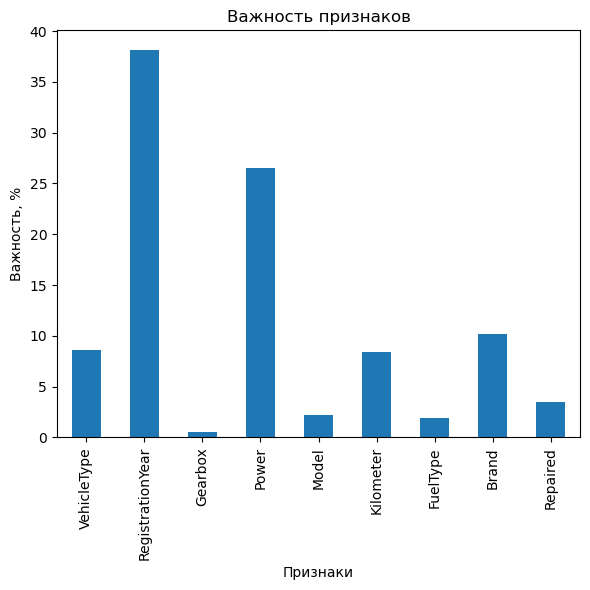

In [77]:
features_importance_cb = pd.Series(model_cb_bp.get_feature_importance(),
                         (features_train).columns)
fig, ax = plt.subplots(figsize=(6, 6))
features_importance_cb.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
ax.set_xlabel('Признаки')
fig.tight_layout()

Наиболее значимые признаки для данной модели Registrationyear, Power, Brand, VehicleType, Kilometer

### Исследуем модель LightGBMRegressor

#### C помощью RandomizedSearchCV будем подбирать гиперпараметры

In [78]:
features_train_lg = features_train
features_test_lg = features_test
for col in cat_columns:
    features_train_lg[col] = features_train_lg[col].astype('category')
    features_test_lg[col] = features_test_lg[col].astype('category')
print(features_train_lg.info()) 
print(features_test_lg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191060 entries, 97712 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       191060 non-null  category
 1   RegistrationYear  191060 non-null  int64   
 2   Gearbox           191060 non-null  category
 3   Power             191060 non-null  int64   
 4   Model             191060 non-null  category
 5   Kilometer         191060 non-null  category
 6   FuelType          191060 non-null  category
 7   Brand             191060 non-null  category
 8   Repaired          191060 non-null  category
dtypes: category(7), int64(2)
memory usage: 5.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63687 entries, 6863 to 130988
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       63687 non-null  category
 1   RegistrationYear  63687 non-nu

In [79]:
model_lg = LGBMRegressor(random_seed=RANDOM_STATE)

params_lg = {
    'num_leaves': range(10,100,10),
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
}
grid_lg = RandomizedSearchCV(model_lg,
                         params_lg,
                         n_iter=20,
                         cv=5,
                         scoring='neg_mean_squared_error',
                         verbose=False)


In [80]:
%%time
grid_lg.fit(features_train_lg, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4956.195645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4959.782536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4959.782536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4966.793363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4966.793363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4973.300979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4973.300979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4963.306206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4963.306206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4956.195645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_seed=12345), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                                        'num_leaves': range(10, 100, 10)},
                   scoring='neg_mean_squared_error', verbose=False)

In [81]:
grid_lg.best_params_

{'num_leaves': 90, 'learning_rate': 0.1}

In [82]:
rmse_lg = (_grid_lg.best_score*-1)**0.5
rmse_lg

1581.761634064454

#### Обучим модель LGBMRegressor с параметрами найденными выше ({'num_leaves': 90, 'learning_rate': 0.1}). Получим предсказания и оценим качество модели (RMSE).

In [83]:
%%time
model_cb_lg_bp = LGBMRegressor(random_seed=RANDOM_STATE, learning_rate=0.1, num_leaves=90)
start_time_lg = time.time()
model_cb_lg_bp.fit(features_train_lg, target_train)
end_time_lg = time.time()
fit_time_lg = end_time_lg - start_time_lg
print(fit_time_lg)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 191060, number of used features: 9
[LightGBM] [Info] Start training from score 4963.875746
1.0800023078918457
Wall time: 1.08 s


In [84]:
cv_scores_lg = cross_val_score(model_cb_lg_bp,  features_train_lg, target_train, cv=5,  scoring='neg_mean_squared_error')
rmse_lg_cv= (cv_scores_lg*-1)**0.5
print(rmse_lg_cv)
rmse_lg_cv_mean = rmse_lg_cv.mean().round(2)
rmse_lg_cv_mean

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4956.195645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 152848, number of used features: 9
[LightGBM] [Info] Start training from score 4959.782536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

1581.62

In [88]:
%%time
start_time_lg = time.time()
predictions_lg = model_cb_lg_bp.predict(features_train_lg)
end_time_lg = time.time()
pred_time_lg = end_time_lg - start_time_lg
print(pred_time_lg)

0.7132511138916016
Wall time: 713 ms


#### Посмотри, какие признаки были наиболее значимы для данной модели.

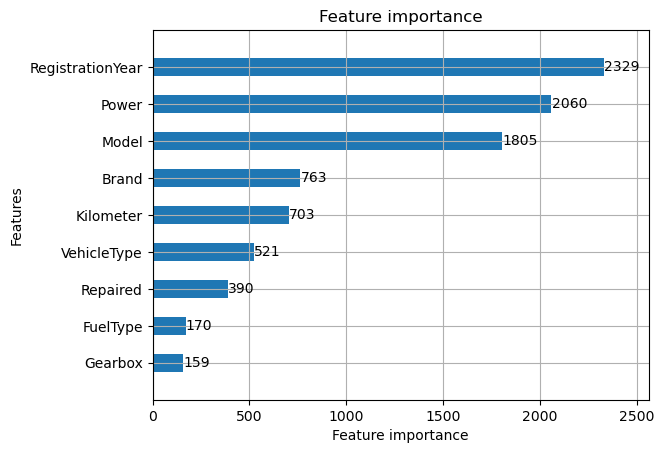

In [89]:
lgb.plot_importance(model_cb_lg_bp, height=.5);

Для этой модели наиболее значимые признаки Registrationyear, Power, Model, Kilometer, Brand, VehicleType 

### **Вывод**
На данном этапе нами были исследованы 4 модели - RandomForestRegressor, Ridge, CatBoostRegressor, LightGBM. Три из них RandomForestRegressor, CatBoostRegressor, LightGBM показали уровень точности необходимый для поставленной задачи (RMSE < 2500). Далее сравним качесто данных моделей, скорости их обучения и предсказания.

## Анализ моделей

Для удобства сравнения сведем все нужные параметры в одну таблицу

In [90]:
index = ['RandomForestRegressor',
         'CatBoostRegressor',
         'LightGBM']
data = {'RMSE':[rmse_rf_cv_mean, rmse_cb_cv_mean, rmse_lg_cv_mean],
        'Время обучения модели, сек':[fit_time_rf, fit_time_cb, fit_time_lg],
        'Время предсказания модели, сек':[pred_time_rf, pred_time_cb, pred_time_lg]}
                                          

compare = pd.DataFrame(data=data, index=index)
display(compare)

,RMSE,"Время обучения модели, сек","Время предсказания модели, сек"
RandomForestRegressor,1961.56,13.227543,1.751989
CatBoostRegressor,1742.19,7.073997,0.574126
LightGBM,1581.62,1.080002,0.713251


**Вывод:**
Из сравнительной таблицы видим, что LightGBM получается лучшей по двум параметрам из трех  При этом время предсказания у нее самое большое, но в целом сопоставимое со скоростью предсказния RandomForestRegressor и CatBoostRegresso. Поэтому рекомендуем к применению - LightGBM.   

Протестируем лучшую модель на тестовой выборке

In [91]:
%%time
start_time_lg = time.time()
predictions_lg_test = model_cb_lg_bp.predict(features_test_lg)
end_time_lg = time.time()
pred_time_lg = end_time_lg - start_time_lg
print('RMSE', mean_squared_error(target_test, predictions_lg_test, squared=False).round(2))
print(pred_time_lg)

RMSE 1562.73
0.22042083740234375
Wall time: 220 ms


Проверим лучшую модель на адекватность сравнив ее с константной моделью DummyRegressor

In [92]:
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(features_train, target_train)
predictions = model_dr.predict(features_test)
print('RMSE', mean_squared_error(target_test, predictions, squared=False).round(2))

RMSE 4679.8


Мы получили, что RMSE конмьтантной модели значительно хуже RMSE LightGBM, следовательно наша молдель адекватна.

**Итоговый вывод**:
В процессе решения задачи регресии по оценке стоимости автомобиля, на основании исторических данных: технические характеристики, комплектации и цены автомобилей, было проджелано следующее:

1. Загружены и исследованы данные (удалены явные дубликаты, заполнены пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired, удалены выбросы и аномальные значения) 

2. Разбили датасет на обучающую выборку. Подобрали гиперпараметры и обучили  4 модели - RandomForestRegressor, Ridge, CatBoostRegressor, LightGBM. Три из них RandomForestRegressor, CatBoostRegressor, LightGBM показали уровень точности необходимый для поставленной задачи (RMSE < 2500). Модель Ridge не дала необходимой точности предсказаний, поэтому далее ее не рассматривали.

3. Провели сравнительный анализ трех параметров (RMSE;	Время обучения модели, сек;	Время предсказания модели, сек) моделей RandomForestRegressor, CatBoostRegressor, LightGB.
LightGBM получается лучшей по двум параметрам из трех (точность предсказания -1581.62 и время обучения модели - 1.080002 сек). При этом время предсказания у нее - 0.713251 с, но в целом сопоставимое со скоростью предсказния RandomForestRegressor - 1.751989 с и CatBoostRegressor - 0.574126 с.

Проверели лучшую модель на тестовой выборке и получили следующие результаты - RMSE 1562.73, время предсказания 0.2204 сек. 
Проверели модель на адеквватность, сравнив ее с константной моделью. Модель адекватна.

Исходя из этого рекоммендуем к применению модель LightGB.